In [48]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import preprocessing as pp

In [49]:
house_sample = pp.house_sample
house_sample.shape

(2219, 23)

## Finding correlations between independent and dependent variables

In [50]:
# finding independent features that are correlated with the dependent variable (price)
corr_mat = house_sample.loc[:,((house_sample.dtypes != np.object) & (house_sample.columns != "Date"))].corr()

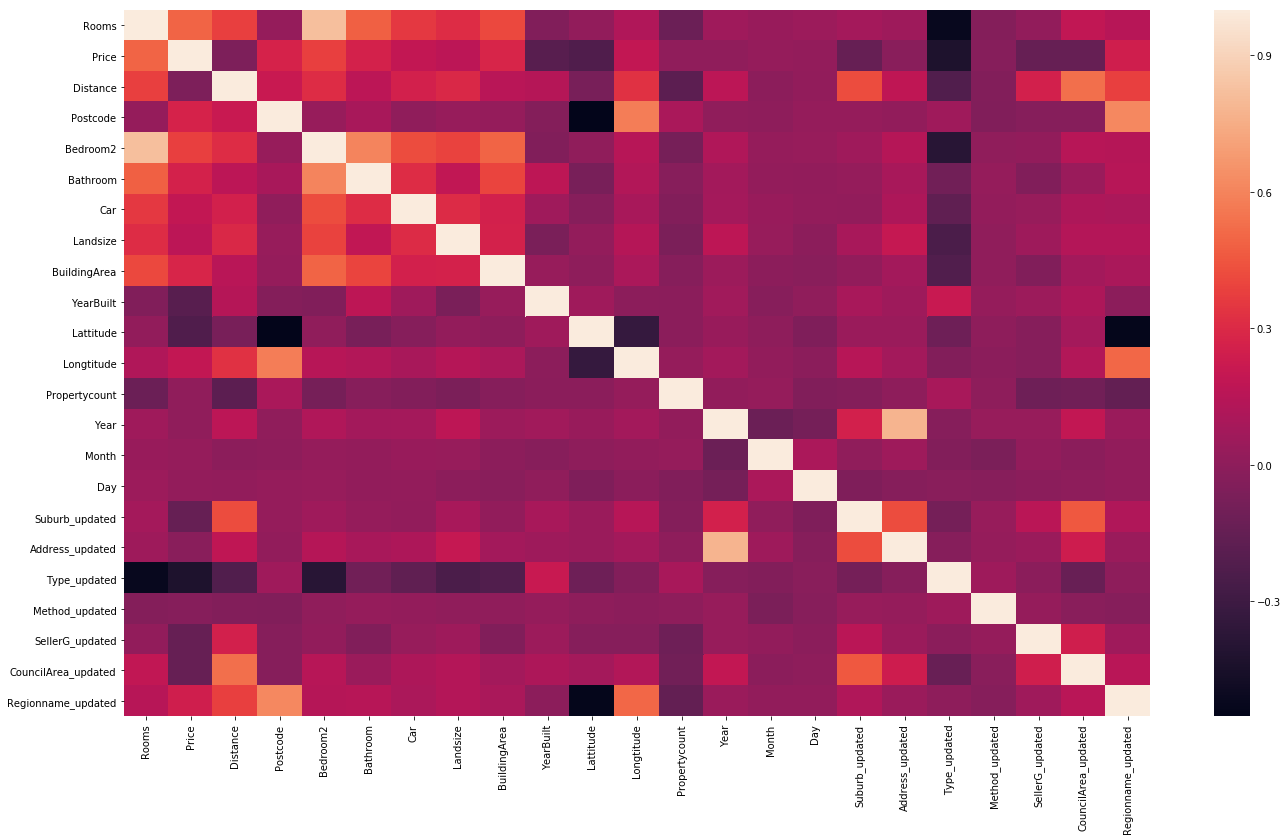

In [51]:
plt.rcParams["figure.figsize"] = (23,13)
sns.heatmap(corr_mat)
plt.show()

The target, dependent variable in this model is going to be the "Price" column. We are going to use the correlation matrix above to find the independent features most correlated with "Price".

Independent Features most correlated with Price:

1. Rooms
2. Bedroom2
3. Bathroom

So we looked at correlations that were greater than or equal to 0.50. We can be confident that 3 features meet this criteria, but lets try to find more features using a different technique.

## Finding optimal independent features for model performance

We don't how many independent features to keep to make sure our model is performing optimally. In this situation, we will use a combination of grid search and piplines to find the most optimal combination of independent features for our model.

In [52]:
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

In [53]:
def pipe_opt(model_name,model):
    kbest = SelectKBest(f_regression)
    pipeline = Pipeline([('kbest',kbest),(model_name,model)])
    return pipeline

def get_accuracy(model):
    cv = cross_val_score(model,X_train,y_train,cv=5)
    cv_pred = cross_val_predict(model,X_test,y_test,cv=5)
    accuracy = metrics.r2_score(y_test,cv_pred)
    
    print("Cross Validated Score: ",cv)
    print("Cross-Predicted Accuracy: ",accuracy)

In [54]:
X = house_sample.loc[:,(house_sample.columns != "Price")]
y = house_sample.loc[:,"Price"]

In [55]:
X.shape

(2219, 22)

In [56]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=42)

In [57]:
X_train.shape

(1775, 22)

### Multivariate Linear Regression

In [58]:
grid_search = GridSearchCV(pipe_opt('linr',LinearRegression()),{'kbest__k':list(range(5,10))})
grid_search.fit(X_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('kbest', SelectKBest(k=10, score_func=<function f_regression at 0x7f24cee92b70>)), ('linr', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'kbest__k': [5, 6, 7, 8, 9]}, pre_dispatch='2*n_jobs',
       refit=True, scoring=None, verbose=0)

In [59]:
grid_search.best_params_

{'kbest__k': 9}

In [60]:
get_accuracy(grid_search)

Cross Validated Score:  [0.40521048 0.41340463 0.42780824 0.35137561 0.43359285]
Cross-Predicted Accuracy:  0.3605463358033225


That's not a very good accuracy score, and there appears to be some slight overfitting. This could mean that there is a either a weak or non-existent linear relationship between the independent and dependent features. Lets try some other models that are better suited for possible nonlinear data.

### Support Vector Machines

In [61]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

c_param = [1,10,100,1000]
kernel_param = ["linear","rbf"]
gamma_param = [0.0001,0.001,0.01,0.1,1]

rand_search_svr = RandomizedSearchCV(pipe_opt('svr',SVR()),{'kbest__k':list(range(5,10)),
                                                  "svr__C": c_param,
                                                  "svr__kernel":kernel_param,
                                                  "svr__gamma":gamma_param},
                                     n_iter=100,cv=3,random_state=42,n_jobs=-1)

In [62]:
sc_X = StandardScaler()
X_train_svr = sc_X.fit_transform(X_train)
X_test_svr = sc_X.transform(X_test)

sc_y = StandardScaler()
y_train_svr = sc_y.fit_transform(y_train.values.reshape(-1,1))
y_test_svr = sc_y.transform(y_test.values.reshape(-1,1))

In [63]:
rand_search_svr.fit(X_train_svr,y_train_svr.ravel())

RandomizedSearchCV(cv=3, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('kbest', SelectKBest(k=10, score_func=<function f_regression at 0x7f24cee92b70>)), ('svr', SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))]),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'kbest__k': [5, 6, 7, 8, 9], 'svr__C': [1, 10, 100, 1000], 'svr__kernel': ['linear', 'rbf'], 'svr__gamma': [0.0001, 0.001, 0.01, 0.1, 1]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [64]:
rand_search_svr.best_params_

{'svr__kernel': 'rbf', 'svr__gamma': 0.1, 'svr__C': 1, 'kbest__k': 8}

Try using randomized search CV first to narrow the range of values, then apply grid search? (not sure how to do with pipelines

In [65]:
c_param2 = [1,2,3,4]
kernel_param2 = ["linear","rbf"]
gamma_param2 = [0.09,0.1,0.2,0.3]
grid_search_cv = GridSearchCV(pipe_opt('svr',SVR()),{'kbest__k':list(range(5,10)),
                                                    'svr__C':c_param2,
                                                    'svr__kernel':kernel_param2,
                                                    'svr__gamma':gamma_param2},
                             cv = 3,n_jobs=-1)

In [66]:
grid_search_cv.fit(X_train_svr,y_train_svr.ravel())

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('kbest', SelectKBest(k=10, score_func=<function f_regression at 0x7f24cee92b70>)), ('svr', SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'kbest__k': [5, 6, 7, 8, 9], 'svr__C': [1, 2, 3, 4], 'svr__kernel': ['linear', 'rbf'], 'svr__gamma': [0.09, 0.1, 0.2, 0.3]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [67]:
grid_search_cv.best_params_

{'kbest__k': 9, 'svr__C': 1, 'svr__gamma': 0.2, 'svr__kernel': 'rbf'}

In [71]:
svr_cv_train = cross_val_score(grid_search_cv,X_train_svr,y_train_svr.ravel(),cv=5)
svr_pred = cross_val_predict(grid_search,X_test_svr,y_test_svr.ravel(),cv=5)
svr_accuracy = metrics.r2_score(y_test_svr.ravel(),svr_pred)
    
print("Cross Validated Score: ",svr_cv_train)
print("Cross-Predicted Accuracy: ",svr_accuracy)

Cross Validated Score:  [0.48205318 0.46145091 0.50298459 0.40778188 0.51232349]
Cross-Predicted Accuracy:  0.3605463358033232


## Random Forest

In [72]:
from sklearn.ensemble import RandomForestRegressor

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'kbest__k':list(range(5,10)),
               'rfr__n_estimators': n_estimators,
               'rfr__max_features': max_features,
               'rfr__max_depth': max_depth,
               'rfr__min_samples_split': min_samples_split,
               'rfr__min_samples_leaf': min_samples_leaf,
               'rfr__bootstrap': bootstrap}

In [73]:
rf_rand = RandomizedSearchCV(pipe_opt('rfr',RandomForestRegressor()),random_grid,
                             cv=3,random_state=42,n_jobs=-1)

In [74]:
rf_rand.fit(X_train,y_train)

RandomizedSearchCV(cv=3, error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('kbest', SelectKBest(k=10, score_func=<function f_regression at 0x7f24cee92b70>)), ('rfr', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, mi...imators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'kbest__k': [5, 6, 7, 8, 9], 'rfr__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'rfr__max_features': ['auto', 'sqrt'], 'rfr__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'rfr__min_samples_split': [2, 5, 10], 'rfr__min_samples_leaf': [1, 2, 4], 'rfr__bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose

In [75]:
rf_rand.best_params_

{'rfr__n_estimators': 800,
 'rfr__min_samples_split': 10,
 'rfr__min_samples_leaf': 1,
 'rfr__max_features': 'auto',
 'rfr__max_depth': 90,
 'rfr__bootstrap': True,
 'kbest__k': 8}

In [76]:
param_grid = {'kbest__k':list(range(8,10)),
               'rfr__n_estimators': [600,800,1000],
               'rfr__max_features': ["auto"],
               'rfr__max_depth': [70,90,110],
               'rfr__min_samples_split': [8,10,12],
               'rfr__min_samples_leaf': [1,2,3],
               'rfr__bootstrap': [True]}

In [77]:
rf_grid = GridSearchCV(pipe_opt('rfr',RandomForestRegressor()),param_grid,
                             cv = 3,n_jobs=-1)

In [78]:
rf_grid.fit(X_train,y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('kbest', SelectKBest(k=10, score_func=<function f_regression at 0x7f24cee92b70>)), ('rfr', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, mi...imators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'kbest__k': [8, 9], 'rfr__n_estimators': [600, 800, 1000], 'rfr__max_features': ['auto'], 'rfr__max_depth': [70, 90, 110], 'rfr__min_samples_split': [8, 10, 12], 'rfr__min_samples_leaf': [1, 2, 3], 'rfr__bootstrap': [True]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [79]:
rf_grid.best_params_

{'kbest__k': 9,
 'rfr__bootstrap': True,
 'rfr__max_depth': 70,
 'rfr__max_features': 'auto',
 'rfr__min_samples_leaf': 3,
 'rfr__min_samples_split': 10,
 'rfr__n_estimators': 600}

In [80]:
get_accuracy(rf_grid)

Cross Validated Score:  [0.52608607 0.50637376 0.54951031 0.49151406 0.52647098]
Cross-Predicted Accuracy:  0.4157948504481165


## Getting top features for predicting house price

In [81]:
# select K best, determined that about 9 features were optimal

selector = SelectKBest(f_regression,k=9)
selector.fit(X_train,y_train)

SelectKBest(k=9, score_func=<function f_regression at 0x7f24cee92b70>)

In [82]:
idxs_selected = selector.get_support()

In [83]:
house_price_features = X_train.columns[idxs_selected]

In [84]:
house_price_features

Index(['Rooms', 'Postcode', 'Bedroom2', 'Bathroom', 'BuildingArea',
       'YearBuilt', 'Lattitude', 'Type_updated', 'Regionname_updated'],
      dtype='object')

If I were a real estate developer and I wanted to determine which factors influence a property's price, then I would probably be interested in knowing about the following:

1. Rooms: number of rooms in the house

2. Postcode: related to location of the house

3. Bedrooms: number of bedrooms

4. Bathrooms: number of bathrooms

5. Building Area: building size in metres (1 metre = 100 cm or 39.37 inches)

6. Year Built: year the house was built

7. Lattitude: related to location of the house

8. Type: type of house (House, Unit, Townhouse)

9. Region Name: general region (west,northwest,north,northeast,etc.) --> related to location of the house

Project improvements:

For the features selected, there appears some slight multicollinearity. For example, postcode, lattitude, and regionname are all related to the location of the property. Maybe applying some dimensionality reduction with these features could improve our model slightly (increasing or decreasing the optimal number of relevant features for predicting house price). 

Also, try to apply pipelines throughout the project (preprocessing and fitting phases) to avoid possible data leaks. We just applied pipelines to our fitting phase.

Try using a boosted model (XGBoost) to try and improve overall accuracy.